# TCC de pós-graduação em Ciência de Dados e Big Data pela PUC Minas 
### Aluno: Samuel Marques Freitas Barbosa
---
Previsão dos preços das ações PETR4 baseado nos preços do dólar, no IBOV e nos preços médios dos combustíveis praticados em Belo Horizonte no mês anterior.

## Coleta e Tratamento dos dados

### Importando as cotações com o yfinance

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import numpy as np
import os
import datetime
import pandas_datareader.data as web
import yfinance as yf
yf.pdr_override()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2022, 12, 31)
petr4 = web.get_data_yahoo('PETR4.SA',start,end) #Petrobrás
ibov = web.get_data_yahoo('^BVSP',start,end) #Ibovespa
dolar = web.get_data_yahoo('USDBRL=X',start,end) #Dólar

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Tratando os dados, pegando as colunas de data e fechamento e adicionando o offset de 7 dias.

In [4]:
petr4 = petr4.reset_index()
petr4['Date'] = pd.to_datetime(petr4["Date"]).dt.date
petr4 = petr4 [['Date', 'Close']]
petr4 = petr4.rename(columns={"Date":"data"})
petr4 = petr4.rename(columns={"Close":"valor_petr4"})

ibov = ibov.reset_index()
ibov['Date'] = pd.to_datetime(ibov["Date"]).dt.date
ibov = ibov [['Date', 'Close']]
ibov = ibov.rename(columns={"Date":"data"})
ibov = ibov.rename(columns={"Close":"valor_ibov"})

dolar = dolar.reset_index()
dolar['Date'] = pd.to_datetime(dolar["Date"]).dt.date
dolar = dolar [['Date', 'Close']]
dolar = dolar.rename(columns={"Date":"data"})
dolar = dolar.rename(columns={"Close":"valor_dolar"})

df_cotacoes = petr4.set_index('data').join(ibov.set_index('data'))
df_cotacoes = df_cotacoes.reset_index()
df_cotacoes = df_cotacoes.set_index('data').join(dolar.set_index('data'))
df_cotacoes = df_cotacoes.reset_index()

### Importação dos dados dos combustíveis, obtidos dos dados abertos do Governo Federal

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
def trata_e_unifica(caminho, df_combustiveis):
  try:
    df = pd.read_csv(caminho,
                          encoding = 'utf-8', 
                            skipinitialspace=True,
                            sep = ';',
                          usecols=[
                              'Data da Coleta'
                              , 'Valor de Venda'
                          ])
  except:
    df = pd.read_csv(caminho,
                          encoding = 'cp1252', 
                            skipinitialspace=True,
                            sep = ';',
                          usecols=[
                              'Data da Coleta'
                              , 'Valor de Venda'
                          ])
  finally:  
    df['Valor de Venda'] = df['Valor de Venda'].str.replace(',', '.')
    df['Valor de Venda'] = pd.to_numeric(df["Valor de Venda"], downcast="float")
    df = df.groupby(['Data da Coleta']).agg({'Valor de Venda': 'mean'}).reset_index()
    df_combustiveis = pd.concat([df_combustiveis, df])
    return df_combustiveis

In [10]:
cwd = os.getcwd()

existe_df = os.path.exists(cwd + '/df_combustiveis.csv')
existe_df = False

if existe_df:
  df_combustiveis = pd.read_csv('df_combustiveis.csv')
else:
  diretorio = '/content/gdrive/MyDrive/Estudos/TCC-Dados/PETR4/'
  arquivos = os.listdir('/content/gdrive/MyDrive/Estudos/TCC-Dados/PETR4/')
  df_combustiveis = pd.DataFrame(columns=[
                              'Data da Coleta'
                              , 'Valor de Venda'
                          ])
  for arquivo in arquivos:
    caminho = diretorio + arquivo
    # adicionado try-except para tratar os diferentes tipos de encoding
    # alguns arquivos estão na codificação UTF-8 e outros na cp1252
    try:
      df = pd.read_csv(caminho,
                            encoding = 'utf-8', 
                              skipinitialspace=True,
                              sep = ';',
                            usecols=[
                                'Data da Coleta'
                                , 'Valor de Venda'
                                , 'Municipio'
                            ])
    except:
      df = pd.read_csv(caminho,
                            encoding = 'cp1252', 
                              skipinitialspace=True,
                              sep = ';',
                            usecols=[
                                'Data da Coleta'
                                , 'Valor de Venda'
                                , 'Municipio'
                            ])
    finally:  
      df['Valor de Venda'] = df['Valor de Venda'].str.replace(',', '.')
      df['Valor de Venda'] = pd.to_numeric(df["Valor de Venda"], downcast="float")
      df = df.query("Municipio == 'BELO HORIZONTE'")
      df.drop('Municipio', axis=1, inplace=True)
      df = df.groupby(['Data da Coleta']).agg({'Valor de Venda': 'mean'}).reset_index()
      df_combustiveis = pd.concat([df_combustiveis, df])
      

<ipython-input-10-f5a7309ca2b4>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('Municipio', axis=1, inplace=True)
<ipython-input-10-f5a7309ca2b4>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('Municipio', axis=1, inplace=True)
<ipython-input-10-f5a7309ca2b4>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('Municipio', axis=1, inplace=True)
<ipython-input-10-f5a7309ca2b4>:43: SettingWithCopyWarning: 
A v

In [11]:
if(not existe_df):
  df_combustiveis['Data da Coleta'] = pd.to_datetime(df_combustiveis['Data da Coleta'], format='%d/%m/%Y').dt.date
  df_combustiveis = df_combustiveis.rename(columns={"Data da Coleta":"data"})
  df_combustiveis = df_combustiveis.rename(columns={"Valor de Venda":"valor_combustiveis"})
  #salvando o df para possibilitar a utilização do git
  df_combustiveis.to_csv('df_combustiveis.csv')
  #!cp df_combustiveis.csv "/content/gdrive/MyDrive/Estudos/TCC-Dados/"

In [12]:
df_cotacoes = df_cotacoes.set_index('data').join(df_combustiveis.set_index('data'), )
df_cotacoes = df_cotacoes.reset_index()

# preenchendo os valores vazios com o último valor não nulo
df_cotacoes['valor_petr4'] = df_cotacoes['valor_petr4'].fillna(df_cotacoes['valor_petr4'].ffill())
df_cotacoes['valor_ibov'] = df_cotacoes['valor_ibov'].fillna(df_cotacoes['valor_ibov'].ffill()).fillna(df_cotacoes['valor_ibov'].bfill())
df_cotacoes['valor_dolar'] = df_cotacoes['valor_dolar'].fillna(df_cotacoes['valor_dolar'].ffill())
df_cotacoes['valor_combustiveis'] = df_cotacoes['valor_combustiveis'].fillna(df_cotacoes['valor_combustiveis'].ffill())

df_cotacoes['data'] = df_cotacoes['data'].astype(str)
df_cotacoes = df_cotacoes.sort_values(by= ['data'])
df = df_cotacoes

# Normalização dos valores

In [13]:
def normalizacao(a):
  minimo = np.min(a)
  maximo = np.max(a)
  a = (a - minimo)/(maximo - minimo)
  return a

In [14]:
def denorm_petr4(a):
  petr4 = df['valor_petr4']
  minimo = np.min(petr4)
  maximo = np.max(petr4)
  a = a * (maximo - minimo) + minimo 
  return a

In [15]:
ibov_norm = normalizacao(df['valor_ibov'])
dolar_norm = normalizacao(df['valor_dolar'])
petr4_norm = normalizacao(df['valor_petr4'])
combustiveis_norm = normalizacao(df['valor_combustiveis'])
periodo = np.arange(len(df))

Text(0.5, 1.0, 'Combustíveis')

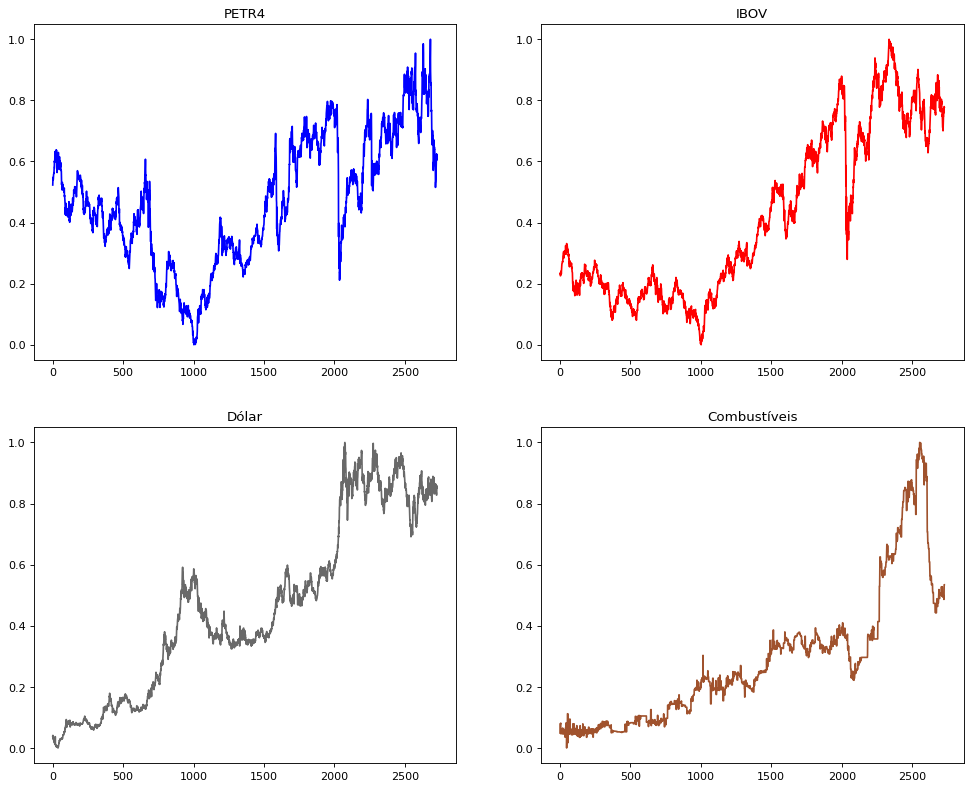

In [16]:
plt.figure(figsize=(15, 12), dpi=80)
plt.subplot(2,2,1)
plt.plot(periodo, petr4_norm,label = "PETR4", linestyle='-', color='blue')
plt.title('PETR4')

plt.subplot(2,2,2)
plt.plot(periodo, ibov_norm, label = "IBOV", linestyle='-', color='red')
plt.title('IBOV')

plt.subplot(2,2,3)
plt.plot(periodo, dolar_norm, label = "Dólar", linestyle='-', color='dimgrey')
plt.title('Dólar')


plt.subplot(2,2,4)
plt.plot(periodo, combustiveis_norm, label = "Combustíveis", linestyle='-', color='sienna')
plt.title('Combustíveis')

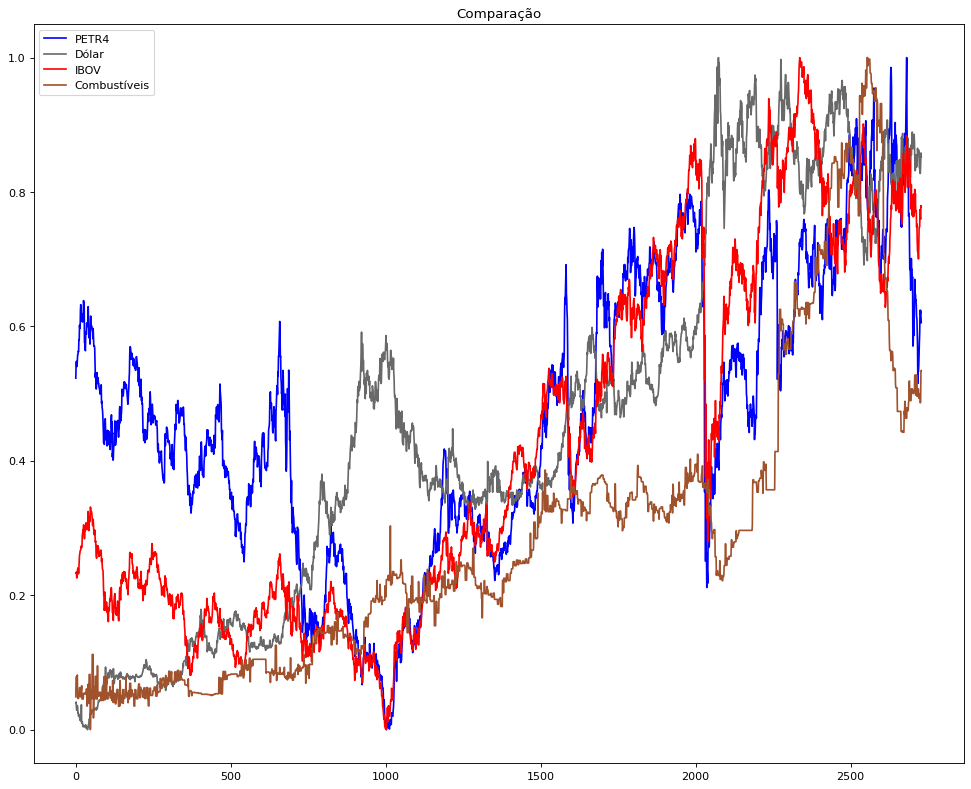

In [17]:
plt.figure(figsize=(15, 12), dpi=80)
plt.plot(periodo, petr4_norm, label = "PETR4", linestyle='-', color='blue')
plt.plot(periodo, dolar_norm, label = "Dólar", linestyle='-', color='dimgrey')
plt.plot(periodo, ibov_norm, label = "IBOV", linestyle='-', color='red')
plt.plot(periodo, combustiveis_norm, label = "Combustíveis", linestyle='-', color='sienna')
plt.title('Comparação')

plt.legend()
plt.show()

# Exploração dos Dados

## Feature engineering: Adicionando a dimensão do preço dos combustíveis em dólar.

In [30]:
df['comb_em_dolar']= df['valor_combustiveis'] / df['valor_dolar']
df['comb_em_dolar'] = df['comb_em_dolar'].fillna(df['comb_em_dolar'] .ffill())
comb_em_dolar_norm = normalizacao(df['comb_em_dolar'])

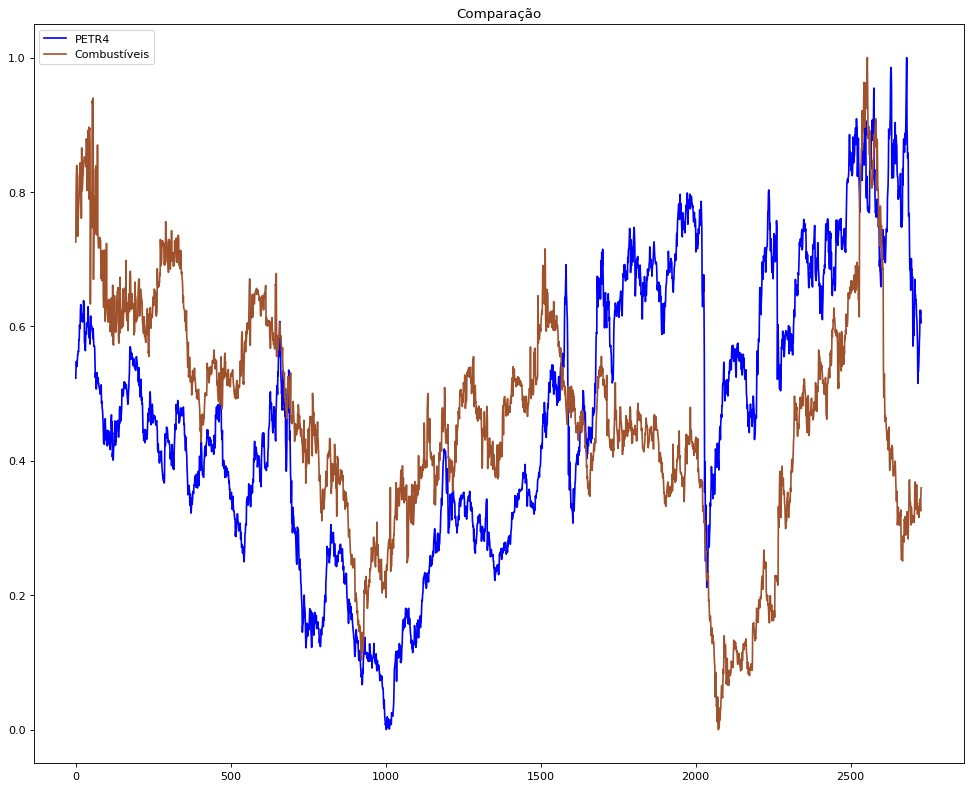

In [31]:
plt.figure(figsize=(15, 12), dpi=80)
plt.plot(periodo, petr4_norm, label = "PETR4", linestyle='-', color='blue')
plt.plot(periodo, comb_em_dolar_norm, label = "Combustíveis", linestyle='-', color='sienna')
plt.title('Comparação')

plt.legend()
plt.show()

## Observando o comportamento da variável a ser explicada

<ipython-input-32-ba563ea7644b>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=eixo[0])
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


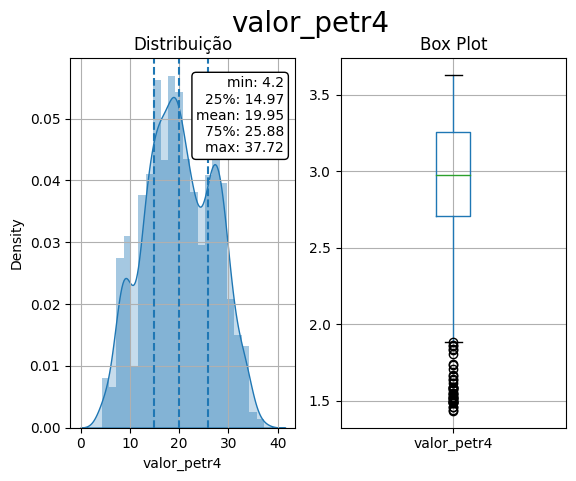

In [32]:
x = "valor_petr4"
figura, eixo = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
figura.suptitle(x, fontsize=20)
### distribution
eixo[0].title.set_text('Distribuição')
variable = df[x].fillna(df[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=eixo[0])
des = df[x].describe()
eixo[0].axvline(des["25%"], ls='--')
eixo[0].axvline(des["mean"], ls='--')
eixo[0].axvline(des["75%"], ls='--')
eixo[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
eixo[0].text(0.95, 0.95, box, transform=eixo[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
### boxplot 
eixo[1].title.set_text('Box Plot')
tmp_df = pd.DataFrame(df[x])
tmp_df[x] = np.log(tmp_df[x])
tmp_df.boxplot(column=x, ax=eixo[1])
plt.show()

## Observando quais variáveis se correlacionam mais ou menos com o preço

<ipython-input-33-82588669476b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matriz = df.corr(method="pearson")


Text(0.5, 1.0, 'Correlação de Pearson')

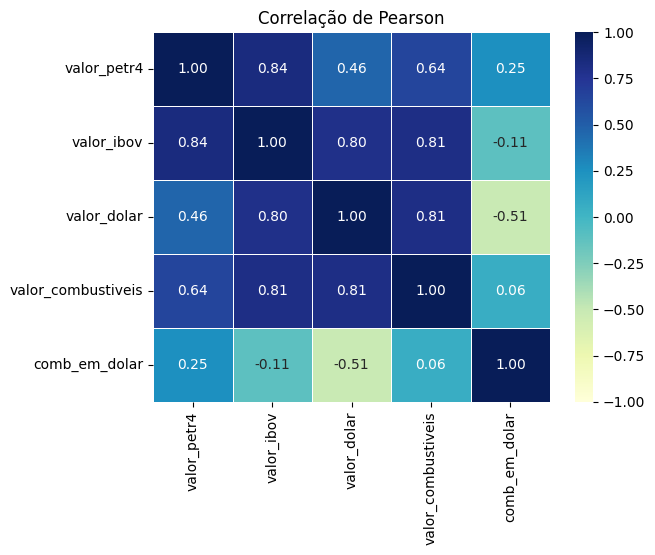

In [33]:
import seaborn as sns
matriz = df.corr(method="pearson")
sns.heatmap(matriz, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("Correlação de Pearson")

## Executando o feature selection para identificar as variáveis mais adequadas

<Axes: xlabel='selection', ylabel='features'>

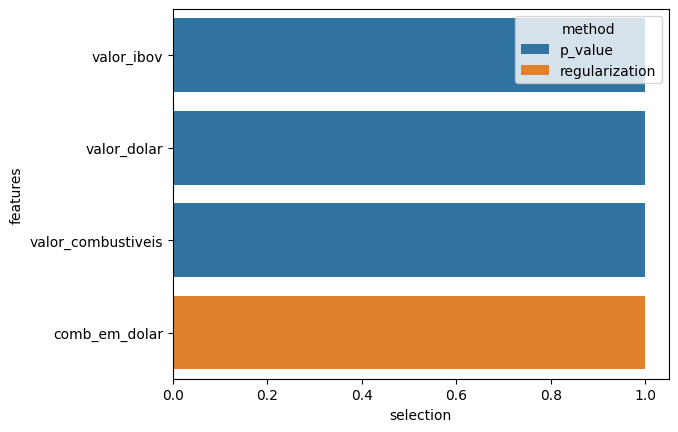

In [34]:
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

X = df.drop(["valor_petr4", "data"], axis=1).values
y = df["valor_petr4"].values
feature_names = df.drop(["valor_petr4", "data"], axis=1).columns
## p-value
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_regression, k=3).fit(X,y)
pvalue_selected_features = feature_names[selector.get_support()]

## regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.Ridge(alpha=1.0, fit_intercept=True), 
                                 max_features=3).fit(X,y)
regularization_selected_features = feature_names[selector.get_support()]
 
## plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["p_value"] = dtf_features["features"].apply(lambda x: "p_value" if x in pvalue_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in pvalue_selected_features else 0)
dtf_features["regularization"] = dtf_features["features"].apply(lambda x: "regularization" if x in regularization_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in regularization_selected_features else 0)
dtf_features["method"] = dtf_features[["p_value","regularization"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
dtf_features["method"] = dtf_features["method"].apply(lambda x: "both" if len(x.split()) == 2 else x)
sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False), dodge=False)

## Observando a importância das variáveis usando Gradient Boosting

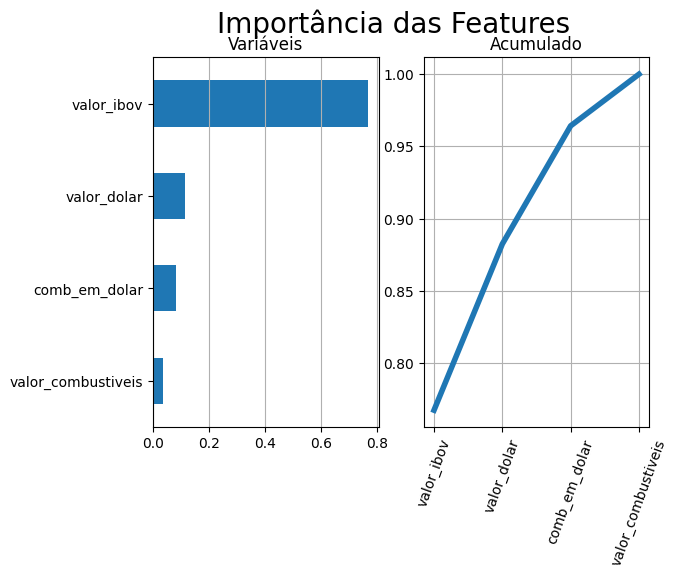

In [35]:
modelo = ensemble.GradientBoostingRegressor()

modelo.fit(X,y)
importancia = modelo.feature_importances_

dtf_importancia = pd.DataFrame({"IMPORTANCIA":importancia, 
            "VARIAVEL":feature_names}).sort_values("IMPORTANCIA", 
            ascending=False)
dtf_importancia['cumsum'] = dtf_importancia['IMPORTANCIA'].cumsum(axis=0)
dtf_importancia = dtf_importancia.set_index("VARIAVEL")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Importância das Features", fontsize=20)
ax[0].title.set_text('Variáveis')
dtf_importancia[["IMPORTANCIA"]].sort_values(by="IMPORTANCIA").plot(
                kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('Acumulado')
dtf_importancia[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importancia)), 
          xticklabels=dtf_importancia.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

## Observando a importância das variáveis no xgboost

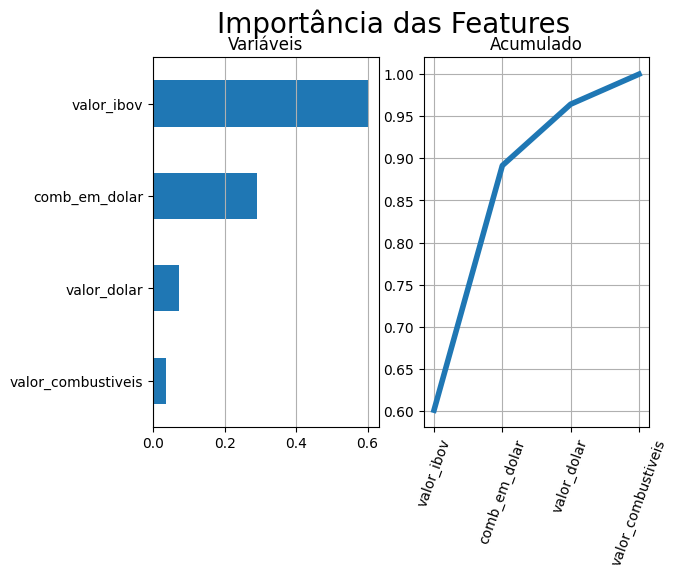

In [36]:
from xgboost import XGBRegressor
modelo = XGBRegressor()

modelo.fit(X,y)
importancia = modelo.feature_importances_

dtf_importancia = pd.DataFrame({"IMPORTANCIA":importancia, 
            "VARIAVEL":feature_names}).sort_values("IMPORTANCIA", 
            ascending=False)
dtf_importancia['cumsum'] = dtf_importancia['IMPORTANCIA'].cumsum(axis=0)
dtf_importancia = dtf_importancia.set_index("VARIAVEL")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Importância das Features", fontsize=20)
ax[0].title.set_text('Variáveis')
dtf_importancia[["IMPORTANCIA"]].sort_values(by="IMPORTANCIA").plot(
                kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('Acumulado')
dtf_importancia[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importancia)), 
          xticklabels=dtf_importancia.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

---
# Modelos

## Preparação inicial


In [37]:
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

In [38]:
y=[]
for a in df['valor_petr4']:
  y.append(a)
y = normalizacao(y)

x = df.drop(['data','valor_petr4'], axis =1)
x = normalizacao(x)

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [39]:
def preparar_dados(dados_serie, look_back):
  X, y =[],[]
  n = len(dados_serie)
  for i in range(n - look_back):
    posicao_fim = i + look_back
    dim = dados_serie.shape[1] -1
    if posicao_fim <= n:
      list_x = []
      seq_x = list(dados_serie[i,0:dim])
      seq_y = dados_serie[posicao_fim,dim]
      X.append(seq_x)
      y.append(seq_y)
  return np.array(X), np.array(y)

In [40]:
#separando em treino e teste
divisao = int(0.8*len(x))
x_treino = x[:divisao]
y_treino = y[:divisao]
x_teste = x[divisao:]
y_teste = y[divisao:]

treino = np.column_stack((x_treino, y_treino))
teste = np.column_stack((x_teste, y_teste))

In [41]:
# adicionando o offset de 5 dias
look_back = 5
x_treino, y_treino = preparar_dados(treino, look_back)
x_teste, y_teste = preparar_dados(teste, look_back)

# Regressão linear

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Variância explicada:  0.7537342148184252
MSE:  0.011385253291208286
MAE:  0.0707033714493592
Erro máximo:  0.4580121316429544
Resultados da validação cruzada: [0.23710251 0.66022007 0.86986187 0.40929044 0.67617402]
Média da validação cruzada: 0.57


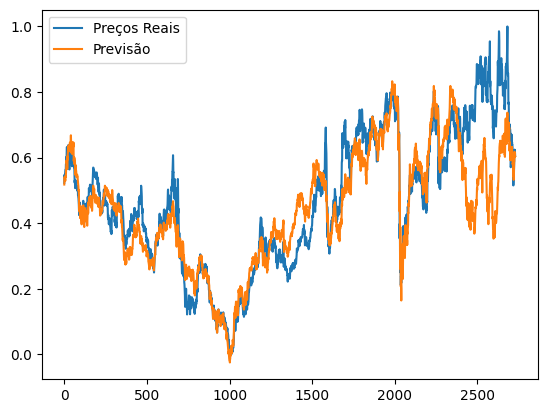

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

modelo = LinearRegression()
modelo.fit(x_treino, y_treino)
lr_accuracy = modelo.score(x_teste, y_teste)
previsao = modelo.predict(x)

print("Variância explicada: ", metrics.explained_variance_score(y, previsao))
print("MSE: ", metrics.mean_squared_error(y, previsao))
print("MAE: ", metrics.mean_absolute_error(y, previsao))
print("Erro máximo: ", metrics.max_error(y, previsao))

resultados = cross_val_score(modelo,x_treino, y_treino, cv=5)

print("Resultados da validação cruzada: {}".format(resultados))
print("Média da validação cruzada: {:.2f}".format(resultados.mean()))

# Gerando o gráfico
plt.plot(normalizacao(df['valor_petr4']), label='Preços Reais')
plt.plot(previsao, label='Previsão')
plt.legend()
plt.show()


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Variância explicada:  0.7537342148184252
MSE:  0.011385253291208286
MAE:  0.0707033714493592
Erro máximo:  0.4580121316429544
Resultados da validação cruzada: [0.23710251 0.66022007 0.86986187 0.40929044 0.67617402]
Média da validação cruzada: 0.57


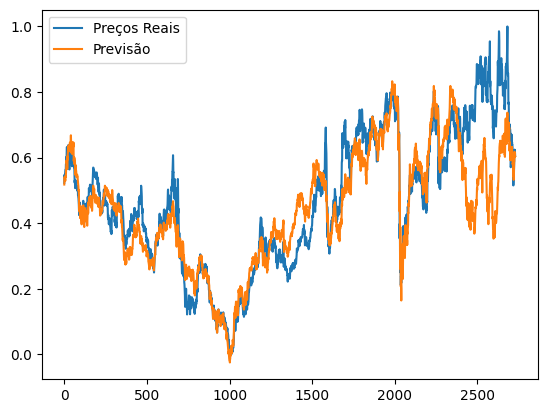

In [46]:
## Regressão utilizando apenas o IBOV
x_ibov = df['valor_ibov']
x_ibov = normalizacao(x)
#separando em treino e teste
divisao = int(0.8*len(x))
x_treino = x_ibov[:divisao]
y_treino = y[:divisao]
x_teste = x_ibov[divisao:]
y_teste = y[divisao:]

treino = np.column_stack((x_treino, y_treino))
teste = np.column_stack((x_teste, y_teste))
# adicionando o offset de 5 dias
look_back = 5
x_treino, y_treino = preparar_dados(treino, look_back)
x_teste, y_teste = preparar_dados(teste, look_back)

modelo = LinearRegression()
modelo.fit(x_treino, y_treino)
lr_accuracy = modelo.score(x_teste, y_teste)
previsao = modelo.predict(x_ibov)

print("Variância explicada: ", metrics.explained_variance_score(y, previsao))
print("MSE: ", metrics.mean_squared_error(y, previsao))
print("MAE: ", metrics.mean_absolute_error(y, previsao))
print("Erro máximo: ", metrics.max_error(y, previsao))

resultados = cross_val_score(modelo,x_treino, y_treino, cv=5)

print("Resultados da validação cruzada: {}".format(resultados))
print("Média da validação cruzada: {:.2f}".format(resultados.mean()))

# Gerando o gráfico
plt.plot(normalizacao(df['valor_petr4']), label='Preços Reais')
plt.plot(previsao, label='Previsão')
plt.legend()
plt.show()

Conclusão: a regressão funcionou melhor utilizando todas as variáveis

# LSTM


In [49]:
# redimensionando os dados
n_caracteristicas = 1 
x_treino = x_treino.reshape((x_treino.shape[0], 
                             x_treino.shape[1], 
                             n_caracteristicas))
x_teste = x_teste.reshape((x_teste.shape[0], 
                       x_teste.shape[1], 
                       n_caracteristicas))
for i in range(5):
  print('treino[{}]: {} -> {}'.format(i+1, x_treino[i], y_treino[i]))

treino[1]: [[0.23336442]
 [0.0392962 ]
 [0.0488619 ]
 [0.72567331]] -> 0.5498209598885225
treino[2]: [[0.23336442]
 [0.04115835]
 [0.07855858]
 [0.80081924]] -> 0.557875865807218
treino[3]: [[0.23443648]
 [0.03265928]
 [0.07855858]
 [0.82728915]] -> 0.5581742019784816
treino[4]: [[0.22565636]
 [0.02881562]
 [0.07855858]
 [0.83960037]] -> 0.5632458030863483
treino[5]: [[0.22623527]
 [0.03468857]
 [0.07855858]
 [0.82087609]] -> 0.5623507945725578


### chat gpt

In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

# Drop the 'date' column
df = df.drop(['data'], axis=1)

# Normalize the data
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df)

# Split the data into training and testing sets
train_size = int(len(df_normalized) * 0.8)
test_size = len(df_normalized) - train_size
train_data, test_data = df_normalized[0:train_size,:], df_normalized[train_size:len(df_normalized),:]


In [52]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape the data for the LSTM model
look_back = 5
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

In [53]:
# Define the LSTM model

earlyStop=EarlyStopping(monitor="loss",verbose=2,mode='min',patience=15)
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 5)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(trainX, trainY, epochs=100, batch_size=25, verbose=2, callbacks=[earlyStop])


Epoch 1/100
88/88 - 4s - loss: 0.0095 - 4s/epoch - 44ms/step
Epoch 2/100
88/88 - 1s - loss: 9.4215e-04 - 550ms/epoch - 6ms/step
Epoch 3/100
88/88 - 1s - loss: 6.3766e-04 - 519ms/epoch - 6ms/step
Epoch 4/100
88/88 - 0s - loss: 6.2560e-04 - 375ms/epoch - 4ms/step
Epoch 5/100
88/88 - 0s - loss: 6.0647e-04 - 319ms/epoch - 4ms/step
Epoch 6/100
88/88 - 0s - loss: 6.1356e-04 - 320ms/epoch - 4ms/step
Epoch 7/100
88/88 - 0s - loss: 5.9596e-04 - 316ms/epoch - 4ms/step
Epoch 8/100
88/88 - 0s - loss: 5.9449e-04 - 307ms/epoch - 3ms/step
Epoch 9/100
88/88 - 0s - loss: 5.7909e-04 - 318ms/epoch - 4ms/step
Epoch 10/100
88/88 - 0s - loss: 5.2596e-04 - 308ms/epoch - 4ms/step
Epoch 11/100
88/88 - 0s - loss: 5.3785e-04 - 391ms/epoch - 4ms/step
Epoch 12/100
88/88 - 0s - loss: 5.9781e-04 - 319ms/epoch - 4ms/step
Epoch 13/100
88/88 - 0s - loss: 4.9709e-04 - 318ms/epoch - 4ms/step
Epoch 14/100
88/88 - 0s - loss: 5.2192e-04 - 299ms/epoch - 3ms/step
Epoch 15/100
88/88 - 0s - loss: 4.7744e-04 - 333ms/epoch - 4ms/

In [54]:
# Evaluate the model
train_score = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, np.sqrt(train_score)))
test_score = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, np.sqrt(test_score)))


Train Score: 0.00 MSE (0.02 RMSE)
Test Score: 0.00 MSE (0.03 RMSE)


In [55]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Reshape trainY and testY to match the shape of trainPredict and testPredict
trainY = trainY.reshape(-1, 1)
testY = testY.reshape(-1, 1)

# Inverse transform the data
trainPredict = denorm_petr4(trainPredict)
trainY = denorm_petr4(trainY)
testPredict = denorm_petr4(testPredict)
testY = denorm_petr4(testY)



17/17 [==============================] - 0s 3ms/step


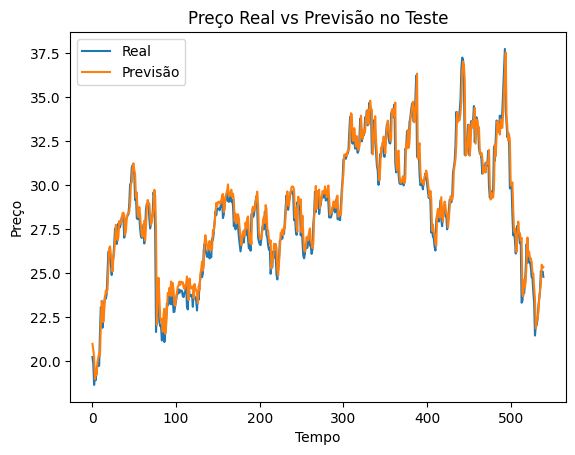

In [56]:
# Plot the actual and predicted prices for the test set
plt.plot(testY, label='Real')
plt.plot(testPredict, label='Previsão')
plt.xlabel('Tempo')
plt.ylabel('Preço')
plt.title('Preço Real vs Previsão no Teste')
plt.legend()
plt.show()

# XGBoost

MSE: 14.48
RMSE: 3.81


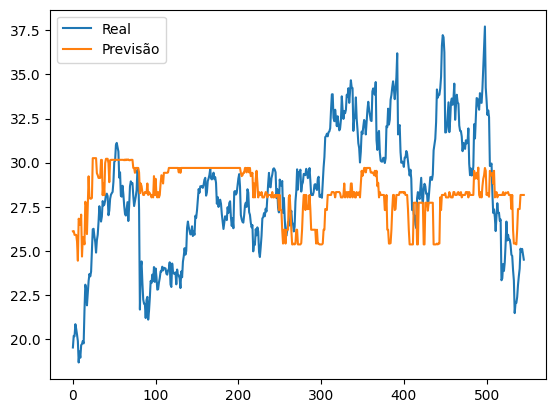

In [47]:
# Usando somente as variáveis mais significativas
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
train_size = int(len(df) * 0.8)

X = x[['valor_ibov', 'valor_combustiveis']]
y = normalizacao(df['valor_petr4'])
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

params = {'gamma': 0, 'learning_rate': 0.8, 'max_depth': 100, 'n_estimators': 1000, 'lambda': 0.8}

model = XGBRegressor(random_state=42, **params)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Avaliando
mse = mean_squared_error(denorm_petr4(y_test), denorm_petr4(y_pred))
rmse = np.sqrt(mse)
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

plt.plot(denorm_petr4(y_test).values, label='Real')
plt.plot(denorm_petr4(y_pred), label='Previsão')
plt.legend()
plt.show()

MSE: 16.19
RMSE: 4.02


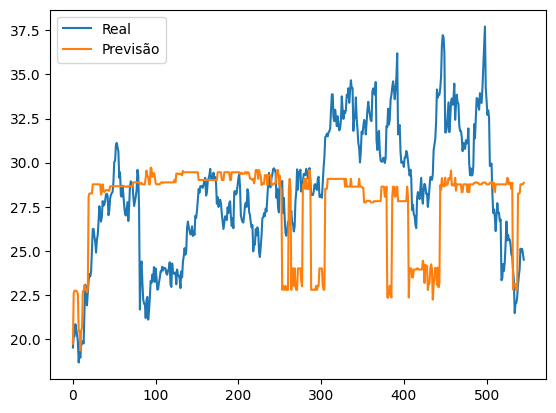

In [48]:
# Usando todas as variáveis
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
train_size = int(len(df) * 0.8)

X = x
y = normalizacao(df['valor_petr4'])
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

params = {'gamma': 0, 'learning_rate': 0.8, 'max_depth': 100, 'n_estimators': 1000, 'lambda': 0.8}

model = XGBRegressor(random_state=42, **params)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Avaliando
mse = mean_squared_error(denorm_petr4(y_test), denorm_petr4(y_pred))
rmse = np.sqrt(mse)
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

plt.plot(denorm_petr4(y_test).values, label='Real')
plt.plot(denorm_petr4(y_pred), label='Previsão')
plt.legend()
plt.show()